In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind , pearsonr ,chi2_contingency
from sklearn.linear_model import LinearRegression 
import warnings
warnings.filterwarnings('ignore')

#pour les tableaux
import plotly.graph_objects as go

import folium

In [2]:
#Chargement des données et vérification des informations - fichier issu du notebook "meteo_4_construction de la base"
data_meteo=pd.read_csv(r"C:\DATA\meteo\data_meteo_traité.csv")
data_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391723 entries, 0 to 391722
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID_station       391723 non-null  int64  
 1   Station          391723 non-null  object 
 2   Latitude         391723 non-null  float64
 3   Longitude        391723 non-null  float64
 4   Altitude         391723 non-null  int64  
 5   distance_Paris   391723 non-null  float64
 6   Date_jour        391723 non-null  object 
 7   Année            391723 non-null  int64  
 8   Numéro_mois      391723 non-null  int64  
 9   Mois             391723 non-null  object 
 10  Température_max  391723 non-null  float64
 11  Jours>30°C       391723 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 35.9+ MB


In [3]:
#Nombre de stations et nombre de lignes
liste_stations=list(data_meteo["ID_station"].unique())
print("Le nombre de stations est:",len(liste_stations))
print("Nombre de lignes du du fichier data_meteo:",data_meteo.shape[0])

#Rappel : sur les 27 ans il y a 9857 dates , soit un manque de 5 jours

Le nombre de stations est: 40
Nombre de lignes du du fichier data_meteo: 391723


In [4]:
#Conservation des infos de station dans un dataframe info_stations
info_stations=data_meteo[["ID_station","Station","Latitude","Longitude","Altitude"]].drop_duplicates()
info_stations=info_stations.reset_index(drop=True)

In [5]:
# PARTIE A : statistiques globales

In [6]:
#Anova sur Température_max , avec les variables "Latitude","Longitude","Altitude","Année","Numéro_mois"
df=data_meteo
var_cible="Température_max"
variables=["Latitude","Longitude","Altitude","Année","Numéro_mois"]

valeur_F=[]
pval=[]
for var_expl in variables:
    var_test=var_cible + "~" + var_expl
    test=ols(var_test,data=df).fit()
    anova=sm.stats.anova_lm(test)
    valeur_F.append((anova["F"][0]).round(2))
    pval.append((anova["PR(>F)"][0]).round(3))

df_anova=pd.DataFrame({"variable":variables,"valeur de F":valeur_F,"p-value":pval}) 
df_anova=df_anova.sort_values(by=["valeur de F"],ascending=False).reset_index(drop=True)


print("Résultat des anova sur la variable cible:\n")
print("Variable cible :",var_cible)
df_anova

#Effet significatif de toutes les variables 
#On note que la variable année est en dernière position ( classement par valeur de F décroissante)

Résultat des anova sur la variable cible:

Variable cible : Température_max


variable  valeur de F  p-value
0     Latitude     18340.02      0.0
1  Numéro_mois     12479.62      0.0
2    Longitude      4045.47      0.0
3     Altitude      2215.60      0.0
4        Année      1081.06      0.0

In [7]:
#Export tableau 1
df_tabl=df_anova
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>variable</b>","<b>valeur de F</b>","<b>p-value</b>"]
#list(df.columns)
trace = go.Table(
   columnorder=[1,2,3,4],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=500, height=500,title_text="<b>Résultats Anova : Température max.</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau1.png")

In [8]:
#Corrélation de Température_max , avec les variables "Latitude","Longitude","Altitude","Année","Numéro_mois"
#Cela donnera les sens de variation 
df=data_meteo
var_cible=df["Température_max"]
variables=["Latitude","Longitude","Altitude","Année","Numéro_mois"]

coeffcorr=[]
pval=[]
pente=[]
ordorig=[]
for var in variables: 
    var_test=df[var]
    coeffcorr.append((pearsonr(var_cible,var_test)[0]).round(4))
    pval.append((pearsonr(var_cible,var_test)[1]).round(4))
    reg = LinearRegression()
    x=np.array(var_test).reshape(-1,1)
    y=np.array(var_cible).reshape(-1,1)
    reg.fit(x,y)
    pente.append((reg.coef_[0][0]).round(4))
    ordorig.append((reg.intercept_[0]).round(2))
    
corr_tmax=pd.DataFrame({"variable":variables,"correlation":coeffcorr,"p-value":pval,"pente":pente,
                          "ord. à l'origine":ordorig}) 

corr_tmax

#Résultats statistiques conformes à l' anova
#La corrélation avec l'année est positive

variable  correlation  p-value   pente  ord. à l'origine
0     Latitude      -0.2115      0.0 -0.6699             47.60
1    Longitude       0.1011      0.0  0.2245             16.09
2     Altitude      -0.0750      0.0 -0.0027             17.08
3        Année       0.0525      0.0  0.0509            -85.65
4  Numéro_mois       0.1757      0.0  0.3848             14.10

In [9]:
# En synthèse

#La latitude l'emporte "largement" par rapport aux autres variables comme explication de la variance
# de la température max.

#L'effet saisonnier est le deuxième effet, à travers la variable mois 


In [10]:
#Paramètres généraux pour les graphiques
couleur_axes="dimgray"
couleur_texte="darkslategray"
liste_années=[1996,2004,2013,2022]
liste_mois=["Jan","Fev","Mar","Avr","Mai","Juin","Juil","Août","Sep","Oct","Nov","Dec"]
liste_stations=["LILLE-LESQUIN","NANTES-BOUGUENAIS","DIJON-LONGVIC","MARIGNANE"]


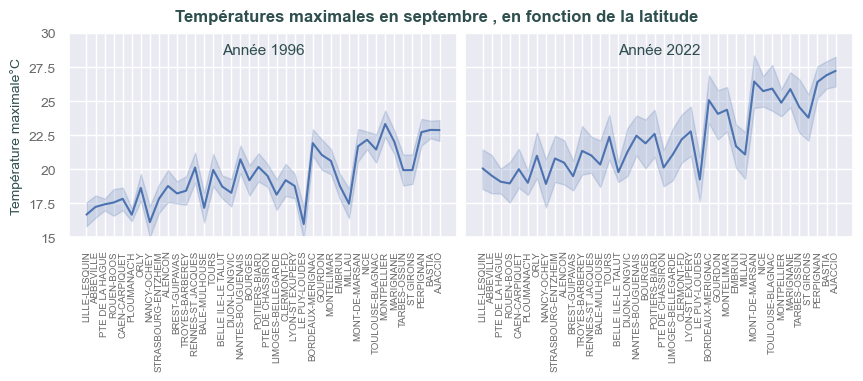

In [11]:
#Illustration de l'effet latitude sur température max en septembre
liste_années2=[1996,2022]
df=data_meteo[(data_meteo["Mois"]=="Septembre")&(data_meteo["Année"].isin(liste_années2))]
df=df.sort_values(by="Latitude",ascending=False)

fig = sns.FacetGrid(df,  col="Année",col_wrap=2, margin_titles=True ,aspect=1.5,despine=False,sharey=True)
fig.map(sns.lineplot,"Station","Température_max")
fig.figure.subplots_adjust(wspace=0.02, hspace=.2)
fig.set(ylim=(15, 30))

fig.set_xticklabels(color=couleur_axes,rotation=90,size=7)
labely=[15,17.5,20,22.5,25,27.5,30]
fig.set_yticklabels(labels=labely,color=couleur_axes,size=10)
fig.set_ylabels("Température maximale°C",color=couleur_texte,size=10)
fig.set_xlabels("")
fig.set_titles(col_template="Année {col_name}",color=couleur_texte,size=11,pad=-15)
plt.subplots_adjust(top=0.90)
plt.suptitle("Températures maximales en septembre , en fonction de la latitude",size=12,color=couleur_texte,fontweight="bold");
#graphe1
fig.savefig("meteo_graphe1")    

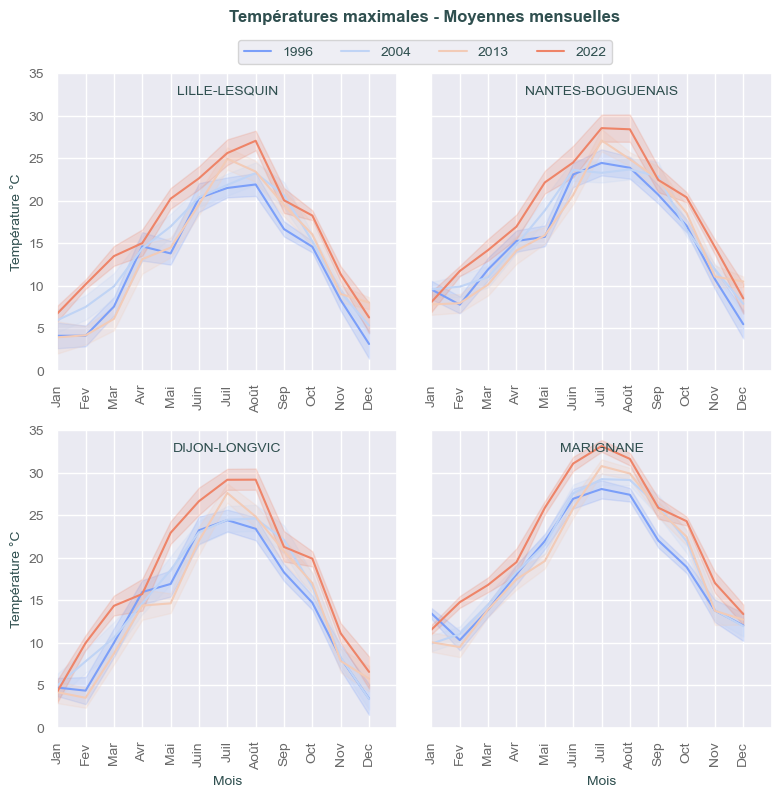

In [12]:
#Effet mois pour la liste de stations et d'années
#Illustration de la dépendance de température max versus mois

df=data_meteo[(data_meteo["Année"].isin(liste_années))&(data_meteo["Station"].isin(liste_stations))] 
fig = sns.FacetGrid(df,  col="Station",col_wrap=2,hue="Année",sharex=False,
                  palette="coolwarm", margin_titles=True ,height=4,despine=False)
fig.map(sns.lineplot, "Mois", "Température_max")
fig.figure.subplots_adjust(wspace=0.1, hspace=.2)
fig.set( ylim=(0, 35),xlim=(1,12))
fig.set_xticklabels(labels=liste_mois,rotation=90,color=couleur_axes,size=10)
labely=[0,5,10,15,20,25,30,35]
fig.set_yticklabels(labels=labely,color=couleur_axes,size=10)
fig.set_axis_labels("Mois","Température °C",color=couleur_texte,size=10)
fig.set_titles(col_template="{col_name}",color=couleur_texte,size=10,pad=-15)

fig.add_legend()
sns.move_legend(fig,"upper center",bbox_to_anchor=(.5, 0.95), ncol=4,
                frameon=True ,title=None,
                fontsize=10,labelcolor=couleur_texte,
               )
plt.subplots_adjust(top=0.90)
plt.suptitle("Températures maximales - Moyennes mensuelles",size=12,color=couleur_texte,fontweight="bold");
#graphe2
fig.savefig("meteo_graphe2")    

In [13]:
#Examen du mois de juillet pour les 4 stations au cours des années
#Analyse corrélation des mois de juillet pour les 4 stations

df=data_meteo[(data_meteo["Station"].isin(liste_stations))&(data_meteo["Mois"]=="Juillet")] 
nom_station=[]
coeffcorr=[]
pval=[]
pente=[]
ordorig=[]
for nom in liste_stations: 
    var_cible=df[df["Station"]==nom]["Température_max"]
    var_test=df[df["Station"]==nom]["Année"]
    nom_station.append(nom)
    coeffcorr.append((pearsonr(var_cible,var_test)[0]).round(4))
    pval.append((pearsonr(var_cible,var_test)[1]).round(4))
    reg = LinearRegression()
    x=np.array(var_test).reshape(-1,1)
    y=np.array(var_cible).reshape(-1,1)
    reg.fit(x,y)
    pente.append((reg.coef_[0][0]).round(4))
    ordorig.append((reg.intercept_[0]).round(2))
    
corr_station=pd.DataFrame({"Station":nom_station,"correlation":coeffcorr,"p-value":pval,"pente":pente,
                           "ord. à l'origine":ordorig}) 

corr_station

Station  correlation  p-value   pente  ord. à l'origine
0      LILLE-LESQUIN       0.2158      0.0  0.1143           -206.53
1  NANTES-BOUGUENAIS       0.1892      0.0  0.1019           -180.32
2      DIJON-LONGVIC       0.2250      0.0  0.1302           -235.67
3          MARIGNANE       0.2822      0.0  0.0987           -168.24

In [14]:
#Export tableau 2
#Pour l'affichage les noms de stations sont raccourcis
df_tabl=corr_station
df_tabl=df_tabl.rename({"Station":"station"},axis=1)
df_tabl["station"]=df_tabl["station"].apply(lambda x:x.split("-")[0])
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>station</b>","<b>correlation</b>","<b>p-value</b>","<b>pente</b>","<b>ord. à l'origine</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=600, height=500,title_text="<b>Corrélation entre Température max. et Année - Mois de juillet</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau2.png")

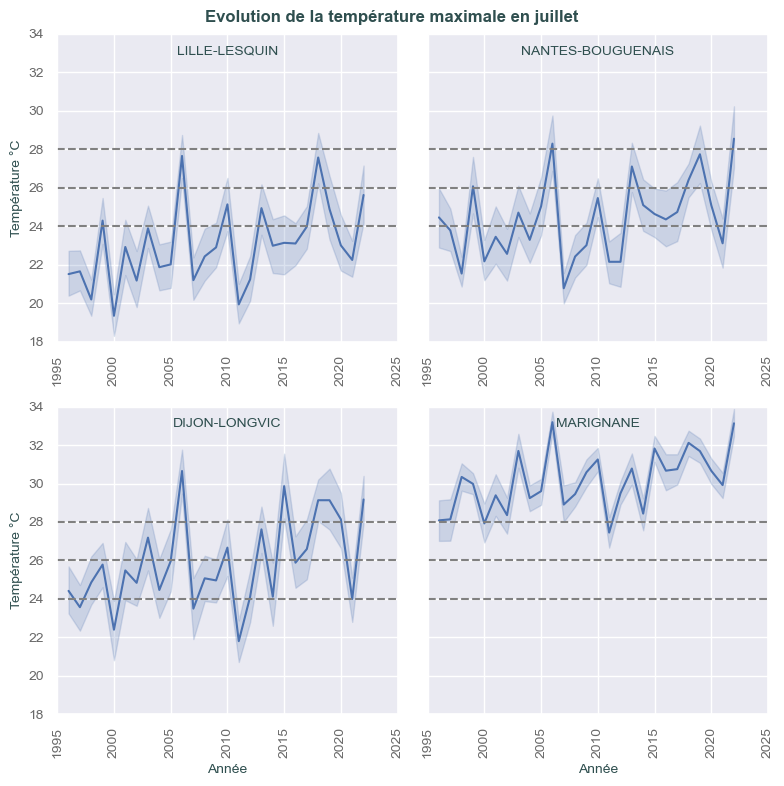

In [15]:
#Graphiques de la température maximale en juillet au cours des années
df=data_meteo[(data_meteo["Station"].isin(liste_stations))&(data_meteo["Mois"]=="Juillet")] 
fig = sns.FacetGrid(df,  col="Station",col_wrap=2,sharex=False,
                  palette="coolwarm", margin_titles=True ,height=4,despine=False)
#fig.map(sns.lineplot, "année", "pred",color="red")
fig.map(sns.lineplot, "Année", "Température_max")
fig.figure.subplots_adjust(wspace=0.2, hspace=.4)
fig.set(xlim=(1996,2022),ylim=(18, 34))
labelx=[1995,2000,2005,2010,2015,2020,2025]
liste_années=np.unique(data_meteo["Année"])
fig.set_xticklabels(labels=labelx,rotation=90,color=couleur_axes,size=10)
labely=[18,20,22,24,26,28,30,32,34]
fig.set_yticklabels(labels=labely,color=couleur_axes,size=10)
fig.set_titles(col_template="{col_name}",color=couleur_texte,size=10,pad=-15)
fig.set_axis_labels("Année", "Température °C",color=couleur_texte,size=10)

fig.refline(y=24)
fig.refline(y=26)
fig.refline(y=28)

plt.subplots_adjust(top=0.95)
plt.suptitle("Evolution de la température maximale en juillet",color=couleur_texte,size=12,fontweight="bold")
#graphe3
fig.savefig("meteo_graphe3")  


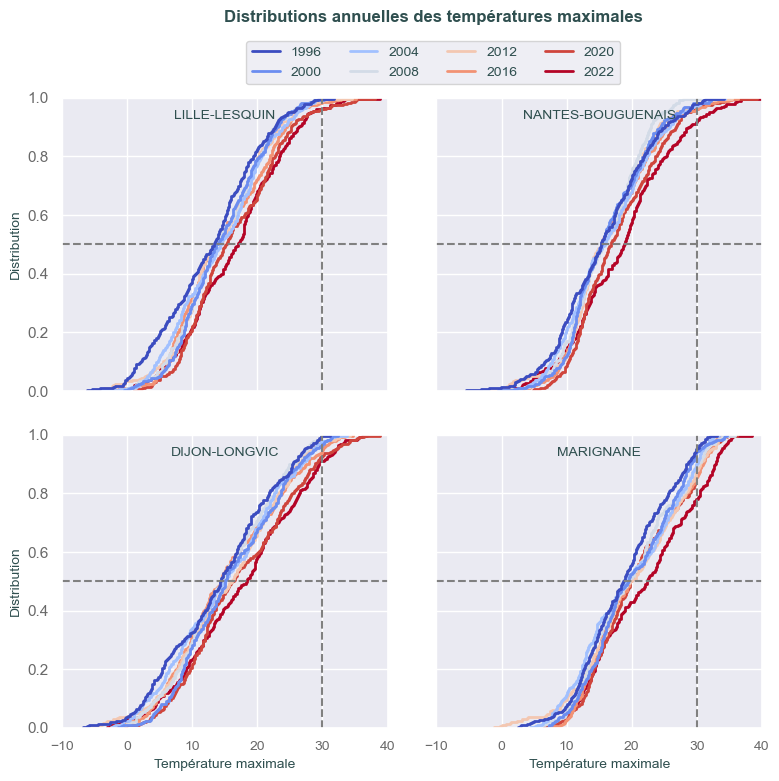

In [16]:
#Evolution de la distribution des températures max
#Distribution des températures maximales poour une sélection de 8 années et les 4 stations choisies
val_test=[1996,2000,2004,2008,2012,2016,2020,2022]
var_cible="Température_max"
var_test="Année"  
labely=[0.0,0.2,0.4,0.6,0.8,1.0]

df=data_meteo[(data_meteo["Station"].isin(liste_stations))&(data_meteo["Année"].isin(val_test))]
    
fig=sns.displot(data=df,x=var_cible,kind="ecdf", hue="Année",col="Station",col_wrap=2,
            height=4,aspect=1,palette="coolwarm",linewidth=2,
            facet_kws={ "despine":False }                
            )
fig.refline(y=0.5,x=30)
fig.figure.subplots_adjust(wspace=0.15, hspace=0.15)
fig.set(xlim=(-10, 40),ylim=(0,1))
fig.set_xticklabels(color=couleur_axes,size=10)
fig.set_yticklabels(labels=labely,color=couleur_axes)
plt.title("")
fig.set_titles(col_template="{col_name}",color=couleur_texte,size=10,pad=-15)
fig.set_axis_labels("Température maximale", "Distribution",color=couleur_texte,size=10)
sns.move_legend(fig,"upper center",bbox_to_anchor=(.5, 0.95), ncol=4,
                frameon=True ,title=None,
                fontsize=10,labelcolor=couleur_texte,
               )
plt.subplots_adjust(top=0.87)
plt.suptitle("Distributions annuelles des températures maximales",color=couleur_texte,size=12,fontweight="bold")

#graphe 4
fig.savefig("meteo_graphe4")      

In [17]:
#On note un glissement des distributions vers les températures plus élevées:

# premier axe : l'évolution de la moyenne des distributions et la quantification des écarts , 

# deuxième axe : l'évolution du nombre de jours à plus de 30°C au cours des années , queue de la distribution


In [18]:
# AXE1 : écart moyenne - Cartographie travail sur l'écart 1996-2022 

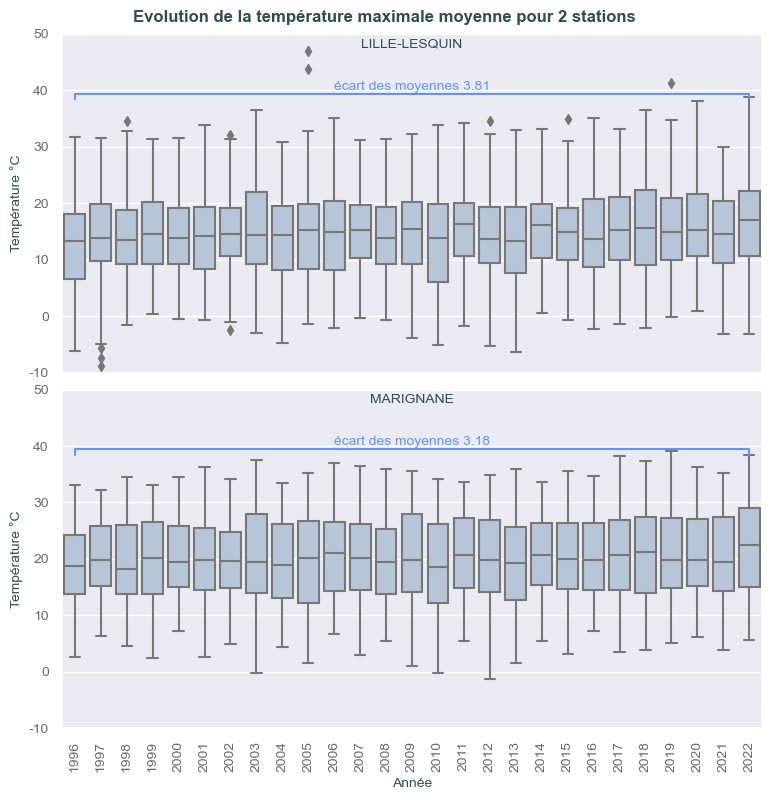

In [20]:
#Graphique d'évolution des écarts pour 4 stations

liste_stations2=["LILLE-LESQUIN","MARIGNANE"]
var_cible="Température_max"
var_test="Année"  

df=data_meteo[data_meteo["Station"].isin(liste_stations2)]
df=df.sort_values(by="Latitude",ascending=False)

fig = sns.FacetGrid(df,  col="Station",col_wrap=1, margin_titles=True ,height=4,aspect=2,
                    sharex=True,sharey=True,despine=False)
fig.map(sns.boxplot, "Année", "Température_max",color="lightsteelblue")

fig.figure.subplots_adjust(wspace=0.05, hspace=0.05)
fig.set(ylim=(-10, 50))
labely=[-10,0,10,20,30,40,50]
fig.set_yticklabels(labels=labely,color=couleur_axes,size=10)
fig.set_xticklabels(color=couleur_axes,rotation=90,size=10)
fig.set_titles(col_template="{col_name}",color=couleur_texte,size=10,pad=-10)
fig.set_axis_labels("Année","Température °C", color=couleur_texte,size=10)

for (col_val), ax in fig.axes_dict.items():
    x1, x2 = 0, 26   # columns '1996' and '2022' 
    moy2022=df[(df["Année"]==2022) & (df["Station"]==col_val)][var_cible].mean()
    moy1996=df[(df["Année"]==1996) & (df["Station"]==col_val)][var_cible].mean()
    ecartmoy=(moy2022-moy1996).round(2)
    y, h, couleur_annot = df[df["Année"]==2022]['Température_max'].max()-0.5 , 1, 'cornflowerblue'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=couleur_annot)
    ax.text((x1+x2)*.5, y+h+0.2,"écart des moyennes "+ str(ecartmoy), ha='center', va='bottom', color=couleur_annot,size=10)  


plt.subplots_adjust(top=0.95)
plt.suptitle("Evolution de la température maximale moyenne pour 2 stations",color=couleur_texte,size=12,fontweight="bold")
#graphe 5
fig.savefig("meteo_graphe5")  



In [21]:
#Calcul des écarts entre 1996 et 202 pour toutes les stations
#Test statistique de Student 

val_test=[1996,2022]

var_cible="Température_max"
var_test="Année"  

station=[]
cond_0=[]
cond_1=[]
t_stat=[]
p_val=[]
ecart=[]
test=[]
liste_test=list(data_meteo["Station"].unique())

for nom in liste_test:
    
    for i in range(len(val_test)):
        df=data_meteo[(data_meteo["Année"].isin(val_test))&(data_meteo["Station"]==nom)]
        for j in np.arange(i+1,len(val_test),1):
            config_0=df[var_cible][df[var_test]==val_test[i]]
            config_1=df[var_cible][df[var_test]==val_test[j]]
            student = ttest_ind(config_0,config_1)
            station.append(nom)
            cond_0.append(val_test[i])
            cond_1.append(val_test[j])
            t_stat.append(student[0].round(4))
            p_val.append(student[1].round(4))
            if student[1]<=0.05:
                resul="oui"
            else:
                resul="non"        
            ecartmoy=(config_1.mean()-config_0.mean()).round(3)
            ecart.append(ecartmoy)
            test.append(resul)
df_ecart=pd.DataFrame({"Station":station,"test_0":cond_0,"test_1":cond_1,"ecart moyenne":ecart,"stat t":t_stat,"p-value":p_val,"<=0.05":test}) 
df_ecart=df_ecart.sort_values(by="ecart moyenne",ascending=False).reset_index(drop=True)

In [22]:
#Description statistique succincte
df_ecart[["ecart moyenne"]].describe()

#Les écarts des moyennes entre 1996 et 2022 , sont significatifs pour toutes les stations.
#La moyenne est 3.1°C

ecart moyenne
count      40.000000
mean        3.109800
std         0.660893
min         1.815000
25%         2.589750
50%         3.167000
75%         3.630500
max         4.469000

In [23]:
#Export tableau 3 ( 5 plus gros écarts et 5 plus petits écarts)

df_ecart_max=df_ecart.head(5)
df_ecart_min=df_ecart.tail(5)
df_tabl=pd.concat([df_ecart_max,df_ecart_min],axis=0)
df_tabl=df_tabl.drop(["test_0","test_1","<=0.05"],axis=1)
df_tabl["classement"]=[1,2,3,4,5,36,37,38,39,40]
df_tabl["Station"]=df_tabl["Station"].apply(lambda x:x.split("-")[0])
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>station</b>","<b>écart(°C)</b>","<b>statistique t</b>","<b>p-value</b>","<b>classement</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=820, height=500,title_text="<b>5 plus forts et 5 plus faibles écarts 1996/2022 sur la moyenne de Température max.</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau3.png")

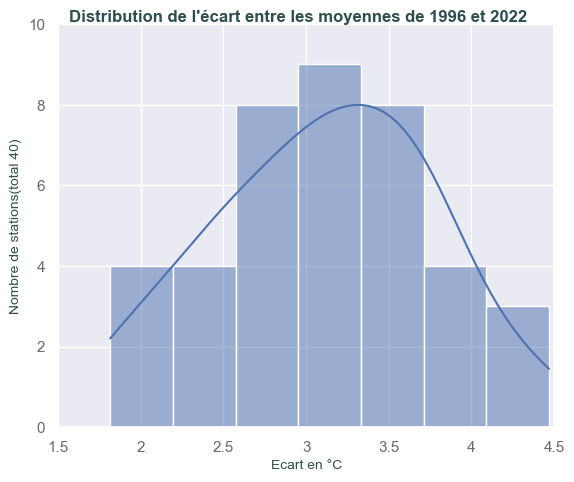

In [24]:
#Distribution des écarts

fig, ax = plt.subplots()
sns.histplot(df_ecart["ecart moyenne"],ax=ax ,kde=True)
ax.set(xlim=(1.5,4.5),ylim=(0,10))
labelx=[1.5,2,2.5,3,3.5,4,4.5]
ax.set_xticklabels(labels=labelx,color=couleur_axes)
labely=[0,2,4,6,8,10]
ax.set_yticklabels(labels=labely,color=couleur_axes)
ax.set_xlabel("Ecart en °C",color=couleur_texte,size=10)
ax.set_ylabel("Nombre de stations(total 40)",color=couleur_texte,size=10)
ax.set_title("",color=couleur_texte,size=11)

plt.subplots_adjust(top=0.95)
plt.suptitle("Distribution de l'écart entre les moyennes de 1996 et 2022",color=couleur_texte,size=12,fontweight="bold")
#graphe 6
fig.savefig("meteo_graphe6")

In [25]:
#Préparation des données pour une carte des écarts entre 1996 et 2022

#Ajout d'une variable classe écart de température
nom_classes=["moins de 2°C","de 2 à 3°C","de 3 à 4°C","plus de 4°C"]
liste_classes=[-10,2,3,4,100]

df_ecart["Classe_écart"]=pd.cut(df_ecart["ecart moyenne"],bins=liste_classes,
                                              labels=nom_classes) 

#Ajout des informations de station , nom , Latitude , Longitude,Altitude
df_ecart=df_ecart.merge(right=info_stations,on="Station",how="inner")


In [26]:
#Carte des écarts entre moyennes de 1996 et 2022
df_ecart=df_ecart[['ID_station','Station','ecart moyenne', 'Classe_écart', 'Latitude', 'Longitude','Altitude']]

#Création du géo dataframe
df_ecart_geo=gpd.GeoDataFrame(df_ecart,geometry=gpd.points_from_xy(df_ecart["Longitude"],df_ecart["Latitude"]))                         
df_ecart_geo=df_ecart_geo.set_crs(epsg="4326")

liste_couleurs=["darkgreen","deepskyblue","orange","red"]
kargs={"location":[46.5,3],"zoom_start":5.5}
fig=df_ecart_geo.explore(tooltip=True,
                     marker_kwds={"radius":8,"fill":True },
                     style_kwds={"fillOpacity":1},
                     column="Classe_écart",
                     legend_kwds={"caption":"Ecart en °C"},
                     cmap=liste_couleurs,
                     legend=True,
                     map_kwds={"scrollWheelZoom":False},
                     **kargs,
    
)

#ajout d'un titre  --> couleur du titre à changer
titre ="Ecart entre les moyennes de températures maximales entre 1996 et 2022"
title_html = '''
             <h3 align="center" style="font-size:14px"><b>{}</b></h3>
             '''.format(titre)   

fig.get_root().html.add_child(folium.Element(title_html))

#folium.Element(titre)

fig

In [27]:
#graphe 7
fig.save("meteo_graphe7")

In [28]:
#Test Anova sur les écarts entre 1996 et 2022 
df_testecart=df_ecart_geo[["ecart moyenne","Longitude","Latitude","Altitude"]]
df_testecart=df_testecart.rename({"ecart moyenne":"ecart_moyenne"},axis=1)
var_cible="ecart_moyenne"
Col=["Latitude","Longitude","Altitude"]

valeur_F=[]
pval=[]
for var_expl in Col:
    var_test=var_cible + "~" + var_expl
    test=ols(var_test,data=df_testecart).fit()
    anova=sm.stats.anova_lm(test)
    valeur_F.append((anova["F"][0]).round(3))
    pval.append((anova["PR(>F)"][0]).round(4))

df_anova=pd.DataFrame({"variable":Col,"valeur de F":valeur_F,"p-value":pval}) 
df_anova=df_anova.sort_values(by=["valeur de F"],ascending=False).reset_index(drop=True)


print("Résultat des anova sur la variable cible:\n")
print("Variable cible :",var_cible)
df_anova


#Dans le cas de la latitude  on ne peut peut rejeter l'hypothèse nulle.
#Il n'y a pas d'effet de la latitude sur l' écart entre les moyennes 1996 et 2022.


Résultat des anova sur la variable cible:

Variable cible : ecart_moyenne


variable  valeur de F  p-value
0   Altitude       14.448   0.0005
1  Longitude       11.490   0.0016
2   Latitude        0.434   0.5142

In [29]:
#Export tableau 4

df_tabl=df_anova
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>variable</b>","<b>valeur de F</b>","<b>p-value</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=500, height=500,title_text="<b>Anova Ecart 1996/2022 sur moyenne de Température max.</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau4.png")

In [30]:
# AXE 2
# Nombre de jours > 30°C par année et par station

In [31]:
#Anova avec jours>30°C par année
df=data_meteo.groupby(["Latitude","Longitude","Altitude","Année"],as_index=False).agg({"Jours>30°C":"sum"})
df=df.rename({"Jours>30°C":"Jours_sup30"}, axis=1)  #on renomme pour le test anova (pb des blancs)
var_cible="Jours_sup30"
variables=["Latitude","Longitude","Altitude","Année"]

valeur_F=[]
pval=[]
for var_expl in variables:
    var_test=var_cible + "~" + var_expl
    test=ols(var_test,data=df).fit()
    anova=sm.stats.anova_lm(test)
    valeur_F.append((anova["F"][0]).round(2))
    pval.append((anova["PR(>F)"][0]).round(4))

df_anova=pd.DataFrame({"variable":variables,"valeur de F":valeur_F,"p-value":pval}) 
df_anova=df_anova.sort_values(by=["valeur de F"],ascending=False).reset_index(drop=True)


print("Résultat des anova sur la variable cible:\n")
print("Variable cible :",var_cible)
df_anova


#Dans le cas de l'altitude  on ne peut peut rejeter l'hypothèse nulle.
#Il n'y a pas d'effet de l'altitude sur le nombre de jours >30°C.



Résultat des anova sur la variable cible:

Variable cible : Jours_sup30


variable  valeur de F  p-value
0   Latitude       321.04   0.0000
1  Longitude       129.52   0.0000
2      Année        75.73   0.0000
3   Altitude         0.08   0.7768

In [32]:
#Corrélation de Jours>30°C , avec les variables "Latitude","Longitude","Altitude","Année"
#Cela donnera les sens de variation
var_cible=df["Jours_sup30"]
variables=["Latitude","Longitude","Altitude","Année"]

coeffcorr=[]
pval=[]
pente=[]
ordorig=[]
for var in variables: 
    var_test=df[var]
    coeffcorr.append((pearsonr(var_cible,var_test)[0]).round(4))
    pval.append((pearsonr(var_cible,var_test)[1]).round(4))
    reg = LinearRegression()
    x=np.array(var_test).reshape(-1,1)
    y=np.array(var_cible).reshape(-1,1)
    reg.fit(x,y)
    pente.append((reg.coef_[0][0]).round(4))
    ordorig.append((reg.intercept_[0]).round(2))
    
df_correl=pd.DataFrame({"variable":variables,"correlation":coeffcorr,"p-value":pval,"pente":pente,
                          "ord. à l'origine":ordorig}) 

df_correl

#La corrélation avec année est positive

variable  correlation  p-value   pente  ord. à l'origine
0   Latitude      -0.4790   0.0000 -2.6497            136.23
1  Longitude       0.3275   0.0000  1.2690             10.75
2   Altitude      -0.0086   0.7768 -0.0005             13.75
3      Année       0.2562   0.0000  0.4338           -857.89

In [33]:
#Export tableau 5
df_tabl=df_anova
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>variable</b>","<b>valeur de F</b>","<b>p-value</b>"]
#list(df.columns)
trace = go.Table(
   columnorder=[1,2,3,4],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=500, height=500,title_text="<b>Résultats Anova : Jours à température >30°C</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau5.png")

In [34]:
#Export tableau 6
df_tabl=df_correl
variable=[df_tabl[var] for var in df_tabl.columns] 
entêtes=["<b>variable</b>","<b>correlation</b>","<b>p-value</b>","<b>pente</b>","<b>ord.origine</b>"]
#list(df.columns)
trace = go.Table(
   columnorder=[1,2,3,4,5],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=530, height=500,title_text="<b>Résultats pearsonr : Jours à température >30°C</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("meteo_tableau6.png")

In [35]:
#Création d'un dataframe de regroupement annuel par station pour préparer les graphiques et les cartes

df_annuel=data_meteo.groupby(["ID_station","Année"],as_index=False).agg({"Jours>30°C":"sum"})

#Ajout des informations de station , nom , Latitude , Longitude,Altitude
df_annuel=df_annuel.merge(right=info_stations,on="ID_station",how="inner")

#Ajout d'une variable classe de nombre de jours
nom_classes=["moins de 10 j","de 10 à 20 j","de 20 à 30 j","de 30 à 40 j","plus de 40 j"]
liste_classes=[-10,10,20,30,40,100]

df_annuel["Classe_jours"]=pd.cut(df_annuel["Jours>30°C"],bins=liste_classes,
                                              labels=nom_classes) 
#Ajouts des couleurs pour les cartes
liste_couleurs=["darkgreen","deepskyblue","blueviolet","chocolate","red"]
df_couleurs=pd.DataFrame({"Classe_jours":nom_classes,"couleur":liste_couleurs})

df_annuel=df_annuel.merge(right=df_couleurs,on="Classe_jours",how="inner")

#Création d'un geodataframe

df_annuel_geo=gpd.GeoDataFrame(df_annuel,geometry=gpd.points_from_xy(df_annuel["Longitude"],df_annuel["Latitude"]))                         
df_annuel_geo=df_annuel_geo.set_crs(epsg="4326")


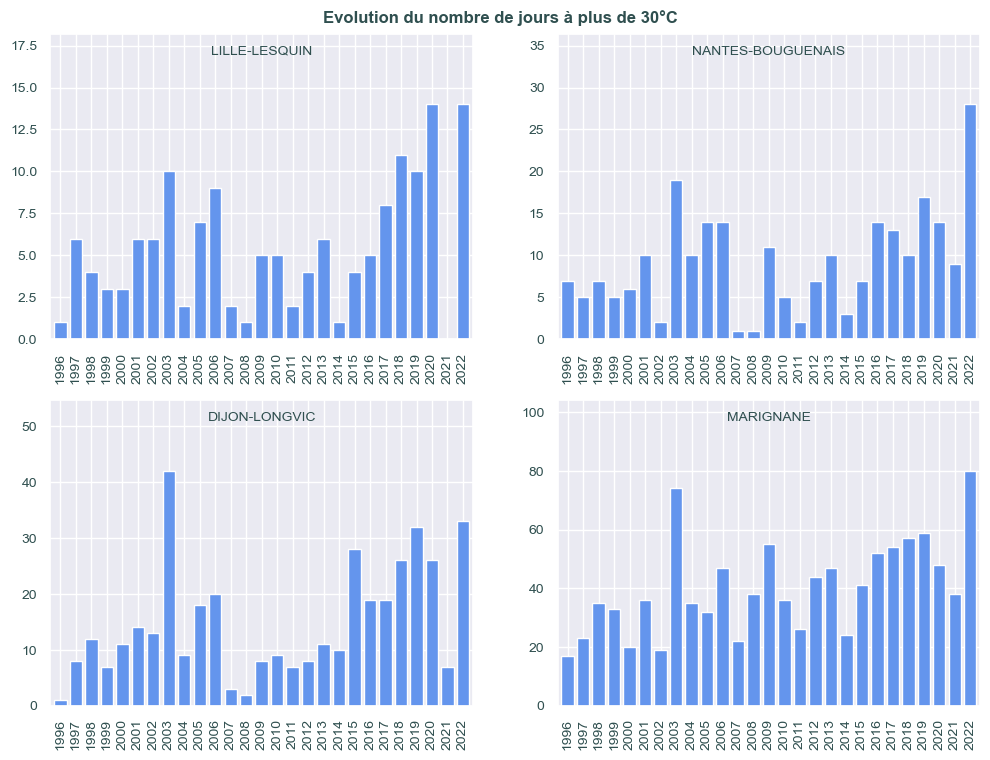

In [36]:
#Graphique d'évolution du nombre de jours > 30°C pour  4 stations

fig, ax = plt.subplots(figsize=(12,8))
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_axis_off()
nb_rg=2
nb_col=2

for i in range(4):
    ax = fig.add_subplot(nb_rg, nb_col, i+1)
    df=df_annuel[df_annuel["Station"]==liste_stations[i]]
    df=df.sort_values(by="Année",ascending=True).reset_index(drop=True)
    df.plot.bar(x="Année",y="Jours>30°C",color="cornflowerblue",ax=ax,legend=False,width=0.8)
    titre =str(df[df["Station"]==liste_stations[i]].iat[0,3])
    ax.set_title(titre,fontdict={'fontsize':10,'color':couleur_texte},pad=-15)
    ech=df["Jours>30°C"].max()*1.3
    ax.set(ylim=(0,ech))
    plt.xlabel("")
    plt.xticks(rotation=90,color=couleur_texte,size=10)
    plt.yticks(color=couleur_texte,size=10)
                       
plt.subplots_adjust(top=0.95)
plt.suptitle("Evolution du nombre de jours à plus de 30°C",color=couleur_texte,size=12,fontweight="bold");

#graphe 8

fig.savefig("meteo_graphe8")

In [37]:
#Statistiques globales
df_annuel[["Jours>30°C"]].describe()

Jours>30°C
count  1080.000000
mean     13.657407
std      13.195164
min       0.000000
25%       3.000000
50%      10.000000
75%      20.000000
max      80.000000

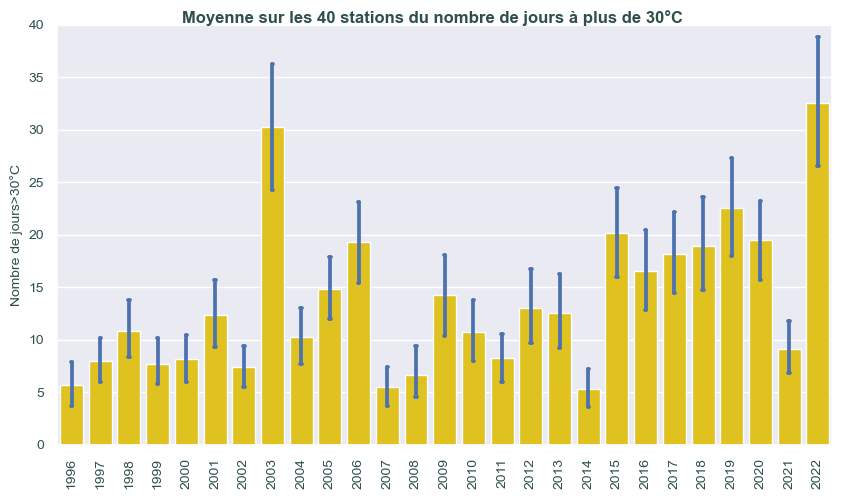

In [38]:
#Graphique de la moyenne des 40 stations
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=df_annuel,x="Année",y="Jours>30°C",color="gold",ax=ax,errorbar="ci",capsize=0.05,errcolor='#4c72b0')
plt.xlabel("")
plt.ylabel("Nombre de jours>30°C",color=couleur_texte,size=10)
plt.xticks(rotation=90,color=couleur_texte,size=10)
plt.yticks(color=couleur_texte,size=10)
plt.ylim([0,40])

plt.subplots_adjust(top=0.95)
plt.suptitle("Moyenne sur les 40 stations du nombre de jours à plus de 30°C",color=couleur_texte,size=12,fontweight="bold");

#graphe 9
fig.savefig("meteo_graphe9")

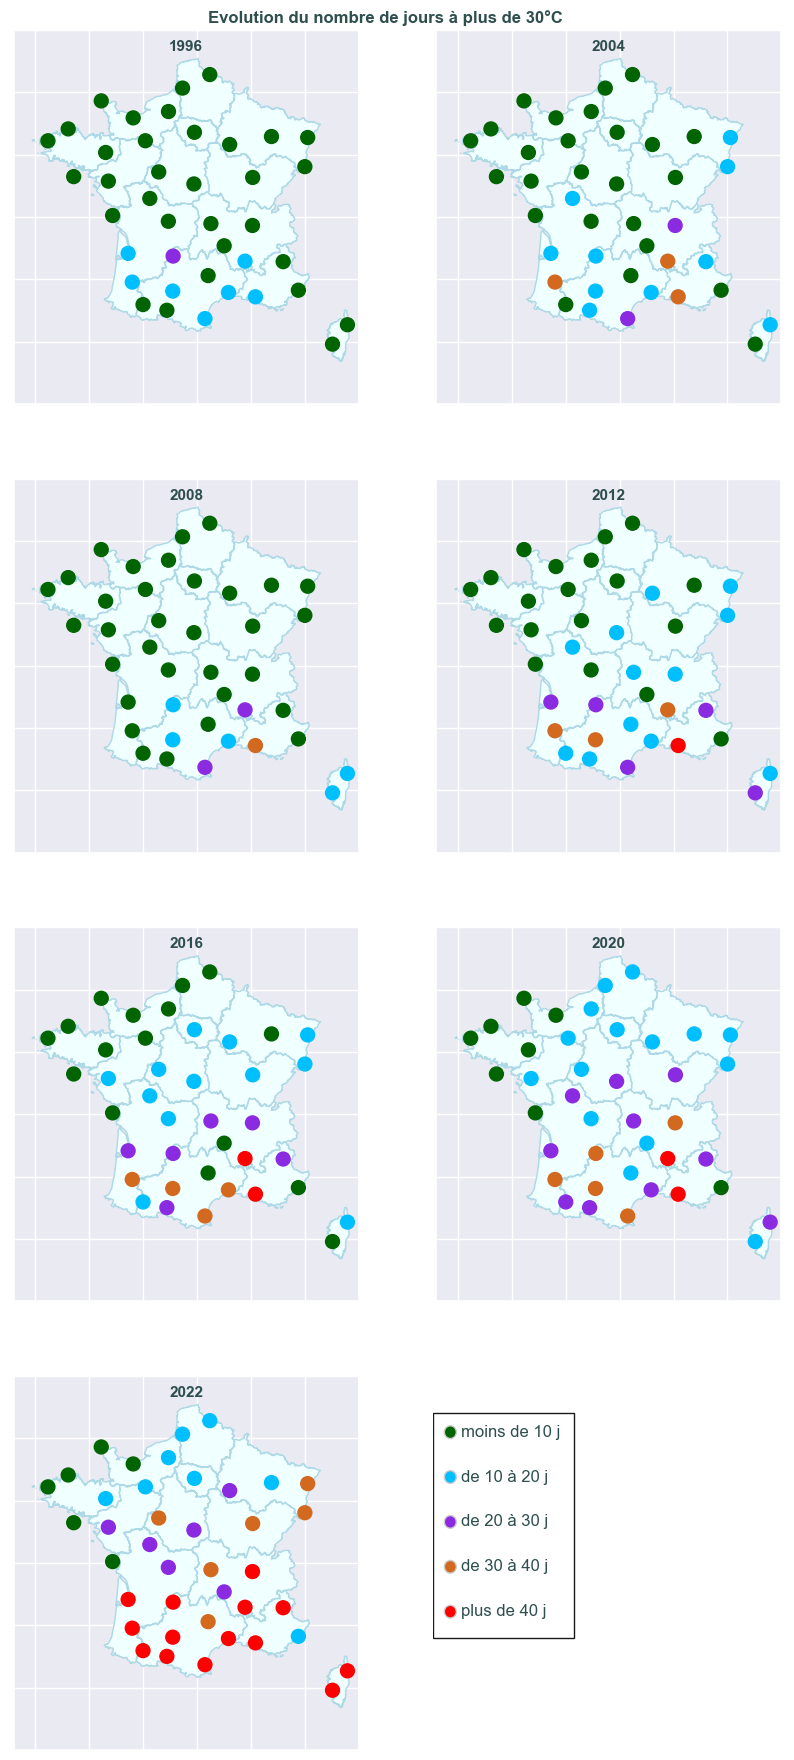

In [40]:
#Cartes simplifiées
from matplotlib.patches import Circle ,Rectangle

#Contour de carte des régions
régions=gpd.read_file(r"C:\DATA\contours_cartes\a-reg2020-geojson.json")
#Filtre pour enlever l'outremer
régions=régions[0:13]


fig, ax = plt.subplots(figsize=(10,20))

#Choix des années
liste_années=[1996,2004,2008,2012,2016,2020,2022]
nb_an=len(liste_années)
nb_col=2
nb_rg=4

ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_axis_off()

for i in range(nb_an):
    ax = fig.add_subplot(nb_rg, nb_col, i+1)
    an=liste_années[i]
    df=df_annuel_geo[df_annuel_geo["Année"]==an].reset_index(drop=True)
    régions.plot(ax=ax,color="azure",edgecolor="lightblue",linewidth=1)
    couleurs=list(df["couleur"])
    labels=list(df["Classe_jours"])
    df.plot(ax=ax,markersize=100,marker="o",c=couleurs,label=labels,legend=True)
    ax.set_title(str(df["Année"][0]),fontdict={'fontsize':11,'color':couleur_texte,'fontweight':"bold"},pad=-15)
    ax.set(xlim=(-6,10),ylim=(40,52))
    ax.set_xticklabels([])
    ax.set_yticklabels([])


plt.subplots_adjust(top=0.97)
plt.suptitle("Evolution du nombre de jours à plus de 30°C",color=couleur_texte,size=12,fontweight="bold");

#Ajout du graphe de légende

ax=fig.add_subplot(nb_rg, nb_col, nb_an +1)
ax.add_patch( Rectangle(xy=(0, 0.3), width=0.4,height=0.6,facecolor="white", edgecolor='0.1') )

for i in range(5):
    col = i
    larg=0.12
    ax.add_patch(Circle(xy=(0.05,0.85-i*larg), radius=0.017, facecolor=df_couleurs["couleur"][i], edgecolor='0.8'))       
    ax.text(0.08,0.85-i*larg, df_couleurs["Classe_jours"][i], fontsize=12,
            horizontalalignment='left',verticalalignment='center',color=couleur_texte)

ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_axis_off()
ax.set_xticklabels([])
ax.set_yticklabels([]);

#graphe 10
fig.savefig("meteo_graphe10")

In [41]:
#FIN ANALYSE